In [16]:
!pip install pydriller

In [ ]:
from pydriller import Repository  # for repository mining and commit analysis
from git import Repo # for direct Git operations and diff generation
import pandas as pd # for data manipulation and analysis
import matplotlib.pyplot as plt # for data visualization

In [ ]:
# Clone selected repositories and configure Git safe directories for analysis
import os, subprocess # for OS operations and running shell commands

repos_to_check = [
    "https://github.com/python-poetry/poetry.git",
    "https://github.com/reflex-dev/reflex.git",
    "https://github.com/jlowin/fastmcp.git"
]

work_dir = "/kaggle/working"
cloned_paths = {}

for link in repos_to_check:
    repo_title = link.split("/")[-1].replace(".git", "")
    dest = f"{work_dir}/{repo_title}"
    if not os.path.exists(dest):
        print("Cloning", repo_title)
        subprocess.run(["git", "clone", link, dest], check=False)
    subprocess.run(["git", "config", "--global", "--add", "safe.directory", dest], check=False)
    cloned_paths[repo_title] = dest


Cloning poetry


Cloning into '/kaggle/working/poetry'...


Cloning reflex


Cloning into '/kaggle/working/reflex'...


Cloning fastmcp


Cloning into '/kaggle/working/fastmcp'...


In [ ]:
# Generate diff output using specified algorithm with whitespace and blank line ignoring
def diff_output(path_repo, commit_sha, algo="default"):
    r = Repo(path_repo)
    commit = r.commit(commit_sha)
    results = {}
    for parent in commit.parents:
        cmd = [
            "git", "-C", path_repo, "diff",
            "--ignore-all-space", "--ignore-blank-lines",
            f"--diff-algorithm={algo}",
            parent.hexsha, commit.hexsha
        ]
        diff_text = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace").stdout
        results[parent.hexsha] = diff_text
    return results


In [ ]:
import csv # for writing results to CSV file

In [ ]:
# Analyze repository commits, generate diffs with both algorithms, and write results to CSV
def explore_repo(repo_loc, repo_tag, csv_path):
    with open(csv_path, "a", newline="", encoding="utf-8") as file:
        w = csv.writer(file)
        for c in Repository(repo_loc).traverse_commits():
            d_myers = diff_output(repo_loc, c.hash, "myers")
            d_hist = diff_output(repo_loc, c.hash, "histogram")

            for f in c.modified_files:
                fname = (f.filename or "").lower()
                if fname.endswith((".py", ".java", ".c", ".cpp")) \
                    or "test" in (f.new_path or "").lower() \
                    or fname in ["readme.md", "license", "license.txt"]:

                    for parent_hash in c.parents:   
                        s1, s2 = d_myers.get(parent_hash, ""), d_hist.get(parent_hash, "")
                        flag = "Yes" if s1 != s2 else "No"
                        w.writerow([repo_tag, f.old_path, f.new_path, c.hash, parent_hash, c.msg.strip(), s1, s2, flag])


In [ ]:
# # Initialize CSV file and process all repositories to generate the final dataset
output_csv = f"{work_dir}/diff_results.csv"

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    wr = csv.writer(f)
    wr.writerow([
        "repo", "old_path", "new_path", "commit_sha", "parent_sha",
        "commit_message", "myers_diff", "hist_diff", "discrepancy"
    ])

for repo_name, path in cloned_paths.items():
    print("Analyzing", repo_name)
    explore_repo(path, repo_name, output_csv)

print("Final dataset written to", output_csv)

Analyzing poetry
Analyzing reflex
Analyzing fastmcp
Final dataset written to /kaggle/working/diff_results.csv


In [ ]:
# Load the generated dataset and set up color theme for visualizations
CSV_PATH = "/kaggle/working/diff_results.csv"  
df = pd.read_csv(CSV_PATH)

# theme
C_ORANGE = "#e67e22"
C_GREEN  = "#2ecc71"
C_BROWN  = "#d2b48c"

In [ ]:
# Adding category classification
def classify_file_type(file_path):
    if not file_path:
        return "Other"
    
    file_path_lower = file_path.lower()
    filename = file_path_lower.split('/')[-1]
    
    if filename.endswith(('.py', '.java', '.c', '.cpp', '.js', '.ts', '.go', '.rs')):
        return "Source"
    
    if 'test' in file_path_lower or filename.startswith('test_') or filename.endswith('_test.py'):
        return "Test"
    
    if filename in ['readme.md', 'readme.txt', 'readme.rst'] or filename.startswith('readme'):
        return "README"
    
    if filename in ['license', 'license.txt', 'license.md'] or filename.startswith('license'):
        return "LICENSE"
    
    return "Other"

df['category'] = df['new_path'].apply(classify_file_type)

In [ ]:
import numpy as np # for numerical operations and handling infinity/NaN values

In [ ]:
# Calculate and display overall mismatch statistics by file category
is_mismatch = df["discrepancy"].astype(str).str.upper() == "YES"


totals = df.groupby("category").size().rename("total_files")
mismatches = df[is_mismatch].groupby("category").size().rename("mismatches")
summary = pd.concat([totals, mismatches], axis=1).fillna(0).astype(int)

summary["mismatch_ratio"] = (
    summary["mismatches"] / summary["total_files"]
).replace([np.inf, np.nan], 0).fillna(0)

summary = summary.sort_values("mismatch_ratio", ascending=False)

# print nice table
summary_print = summary.copy()
summary_print["mismatch_percent"] = (summary_print["mismatch_ratio"] * 100).map("{:.1f}%".format)
print("=== Overall mismatch summary by file category ===\n")
print(summary_print[["total_files", "mismatches", "mismatch_percent"]].to_string())

=== Overall mismatch summary by file category ===

          total_files  mismatches mismatch_percent
category                                          
LICENSE             8           3            37.5%
Test             2038         593            29.1%
Source          24265        6838            28.2%
README            495          97            19.6%


In [ ]:
# Calculate and display per-repository mismatch statistics by file category
repo_totals = df.groupby(["repo", "category"]).size().rename("total").reset_index()
repo_mis    = df[is_mismatch].groupby(["repo", "category"]).size().rename("mismatch").reset_index()
repo_stats  = pd.merge(repo_totals, repo_mis, on=["repo","category"], how="left").fillna(0)
repo_stats["mismatch_ratio"] = (
    repo_stats["mismatch"] / repo_stats["total"]
).replace([np.inf, np.nan], 0).fillna(0)

# pivot into tables
totals_pivot = repo_stats.pivot(index="repo", columns="category", values="total").fillna(0).astype(int)
mis_pivot    = repo_stats.pivot(index="repo", columns="category", values="mismatch").fillna(0).astype(int)
ratio_pivot  = repo_stats.pivot(index="repo", columns="category", values="mismatch_ratio").fillna(0)

print("\n=== Per-repo totals (by category) ===\n")
print(totals_pivot.to_string())
print("\n=== Per-repo mismatches (by category) ===\n")
print(mis_pivot.to_string())
print("\n=== Per-repo mismatch ratio (by category) ===\n")
print(ratio_pivot.applymap(lambda x: f"{x:.1%}").to_string())



=== Per-repo totals (by category) ===

category  LICENSE  README  Source  Test
repo                                   
fastmcp         3     108    3405    70
poetry          2      93   10502  1820
reflex          3     294   10358   148

=== Per-repo mismatches (by category) ===

category  LICENSE  README  Source  Test
repo                                   
fastmcp         2      29    1119    13
poetry          0      12    3061   553
reflex          1      56    2658    27

=== Per-repo mismatch ratio (by category) ===

category LICENSE README Source   Test
repo                                 
fastmcp    66.7%  26.9%  32.9%  18.6%
poetry      0.0%  12.9%  29.1%  30.4%
reflex     33.3%  19.0%  25.7%  18.2%


/tmp/ipykernel_36/2287126725.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(ratio_pivot.applymap(lambda x: f"{x:.1%}").to_string())


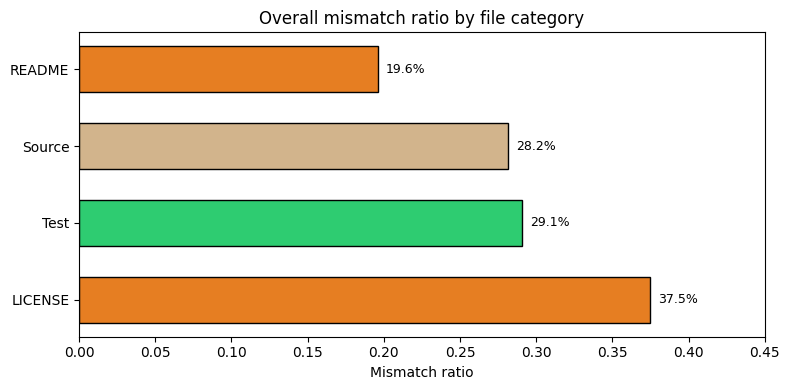

In [ ]:
# Create horizontal bar chart showing overall mismatch ratios by file category
cats = summary.index.tolist()
vals = summary["mismatch_ratio"].values

theme_cols = [C_ORANGE, C_GREEN, C_BROWN]
bar_colors = [theme_cols[i % len(theme_cols)] for i in range(len(cats))]

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(cats, vals, color=bar_colors, edgecolor="black", height=0.6)
ax.set_xlabel("Mismatch ratio")
ax.set_title("Overall mismatch ratio by file category")
ax.set_xlim(0, max(vals.max() * 1.2, 0.05))

for i, v in enumerate(vals):
    ax.text(v + 0.005, i, f"{v:.1%}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


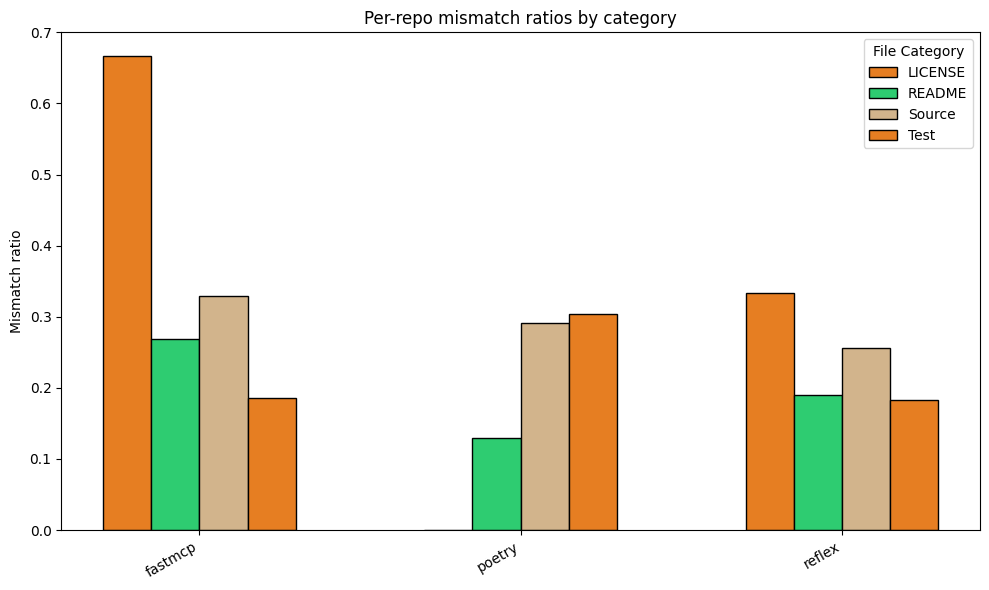

In [ ]:
# Create grouped bar chart showing per-repository mismatch ratios by category
repos = sorted(df["repo"].unique())
categories = sorted(df["category"].unique())

fig, ax = plt.subplots(figsize=(10, 6))
for i, cat in enumerate(categories):
    vals = ratio_pivot[cat].reindex(repos).fillna(0).values
    ax.bar(
        [x + i*0.15 for x in range(len(repos))], vals, width=0.15,
        label=cat, edgecolor="black",
        color=theme_cols[i % len(theme_cols)]
    )

ax.set_xticks([x + 0.15*(len(categories)-1)/2 for x in range(len(repos))])
ax.set_xticklabels(repos, rotation=30, ha="right")
ax.set_ylabel("Mismatch ratio")
ax.set_title("Per-repo mismatch ratios by category")
ax.legend(title="File Category")
plt.tight_layout()
plt.show()


In [ ]:
# quick summary of highest mismatch category and repository rankings
overall_sorted = summary.sort_values("mismatch_ratio", ascending=False)
top_category = overall_sorted.index[0] if not overall_sorted.empty else None
top_ratio = overall_sorted["mismatch_ratio"].iloc[0] if not overall_sorted.empty else None

repo_overall = repo_stats.groupby("repo").apply(
    lambda g: g["mismatch"].sum() / g["total"].sum() if g["total"].sum() > 0 else 0
).sort_values(ascending=False)

print("\n=== Quick summary ===\n")
if top_category:
    print(f"Highest mismatch ratio overall is in category: {top_category} ({top_ratio:.1%})")
else:
    print("No category data available.")

print("\nRepositories ranked by overall mismatch ratio:")
print(repo_overall.map(lambda x: f"{x:.1%}").to_string())



=== Quick summary ===

Highest mismatch ratio overall is in category: LICENSE (37.5%)

Repositories ranked by overall mismatch ratio:
repo
fastmcp    32.4%
poetry     29.2%
reflex     25.4%


/tmp/ipykernel_36/3524130313.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  repo_overall = repo_stats.groupby("repo").apply(
